# Project: Insurance Fraud Detection (DS)
---------------------------------------------

# Dataset Description
All first-party physical damage claims will be filtered by claim handlers and some of them will be referred to the fraud detection team. My data is a sample of these referred claims from 2015 to 2016.



**Variable Descriptions**
* claim_number - Claim ID **(cannot be used in model)**
* age_of_driver - Age of driver
* gender - Gender of driver
* marital_status - Marital status of driver
* safty_rating - Safety rating index of driver
* annual_income - Annual income of driver
* high_education_ind - Driver’s high education index
* address_change_ind - Whether or not the driver changed living address in past 1 year
* living_status - Driver’s living status, own or rent
* zip_code - Driver’s living address zipcode
* claim_date - Date of first notice of claim
* claim_day_of_week - Day of week of first notice of claim
* accident_site - Accident location, highway, parking lot or local
* past_num_of_claims - Number of claims the driver reported in past 5 years
* witness_present_ind - Witness indicator of the claim
* liab_prct - Liability percentage of the claim
* channel - The channel of purchasing policy
* policy_report_filed_ind - Policy report filed indicator
* claim_est_payout - Estimated claim payout
* age_of_vehicle - Age of first party vehicle
* vehicle_category - Category of first party vehicle
* vehicle_price - Price of first party vehicle
* vehicle_color - Color of first party vehicle
* vehicle_weight - Weight of first party vehicle
* fraud - Fraud indicator (0=no, 1=yes). **This is the response variable.**

In [1]:
!gdown 1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq

Downloading...
From: https://drive.google.com/uc?id=1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq
To: /content/train_2023.csv
100% 2.62M/2.62M [00:00<00:00, 19.2MB/s]


In [2]:
#read the data
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train_2023.csv')
df.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,0,50,F,1.0,66,39117,1,0,Own,50051,...,18,Broker,0,5464.903723,3.0,Large,16786.28845,blue,34183.436390,0
1,1,47,M,1.0,78,38498,1,0,Own,50012,...,81,Broker,0,5448.155974,4.0,Large,20793.29881,black,14528.379730,0
2,2,28,M,0.0,76,33343,0,1,Rent,20158,...,94,Broker,1,1858.971699,4.0,Compact,6729.47649,blue,7182.832636,0
3,3,36,M,1.0,56,35832,1,0,Own,50054,...,95,Phone,0,4040.932844,5.0,Compact,24914.26785,gray,47891.788790,0
4,4,60,F,1.0,79,40948,1,1,Rent,80010,...,53,Phone,1,4876.606138,6.0,Medium,17392.41997,black,7546.494014,0


In [3]:
# hint: do you have imbalanced data?
df['fraud'].value_counts() # yes you do!

fraud
0    16062
1     2938
Name: count, dtype: int64

In [4]:
# split the data (don't change this!)

X = df.drop(['claim_number', 'fraud'],axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
# check the shapes
print(df.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19000, 25)
(15200, 23) (15200,)
(3800, 23) (3800,)


# 🔵  Modules

In [6]:
# import the modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer,KNNImputer
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.metrics import classification_report,confusion_matrix,f1_score

In [7]:
# import PDP modules

!pip install pulp # for partial dependence plots!
!pip install pycebox
from pycebox.ice import ice, ice_plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3624 sha256=c60a4e8eb3c701e10d5be0e920a54d4052f0458f57dab48e0bce576344dceb0f
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


# 🔵 EDA, data cleaning and feature engineering

## 🟢 Data Cleaning

###Impute

In [8]:
imputer = KNNImputer(n_neighbors=5)
columns_to_impute = ['witness_present_ind', 'claim_est_payout', 'age_of_vehicle', 'marital_status']

X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])
X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])

###Sampling

In [9]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 1992) #oversampling approach
# fit and apply the transform
X_train, y_train = oversample.fit_resample(X_train, y_train) #actual oversampling on training data
# summarize class distribution
print('AFTER OVERSAMPLING: ', Counter(y_train)) #print counts of fraud after oversampling
print("TEST DATA (UNCHANGED): ", Counter(y_test))

AFTER OVERSAMPLING:  Counter({0: 12853, 1: 12853})
TEST DATA (UNCHANGED):  Counter({0: 3209, 1: 591})


###Big Cleanup

In [10]:
# Defining a function
# Function is converting the datatypes, labelencoding, creating dummy variables

import pandas as pd
from sklearn.preprocessing import LabelEncoder

def process_dataframe(df):
    # Convert claim_date to datetime
    df['claim_date'] = pd.to_datetime(df['claim_date'])

    # Convert zip_code to object
    df['zip_code'] = df['zip_code'].astype('object')

    # Print data types of specific columns
    cols = ['claim_date', 'zip_code']
    print(df[cols].dtypes)

    # Initialize LabelEncoder
    le = LabelEncoder()

    # Encode gender and living_status
    df['gender'] = le.fit_transform(df['gender'])    # 0 is Female & 1 is male
    df['living_status'] = le.fit_transform(df['living_status'])  # 0 is own & 1 is rent

    # Columns to be one-hot encoded
    cols_to_encode = ['accident_site', 'channel', 'vehicle_category', 'vehicle_color', 'claim_day_of_week']

    # Ensure the columns to be encoded are present in the DataFrame
    missing_cols = [col for col in cols_to_encode if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns for one-hot encoding: {missing_cols}")

    # One-hot encode specified columns and concatenate to the original DataFrame
    df = pd.concat([df, pd.get_dummies(df[cols_to_encode], dtype=int)], axis=1)

    # Drop the original columns that were one-hot encoded
    df.drop(columns=cols_to_encode, inplace=True)

    return df



X_train = process_dataframe(X_train)
X_test = process_dataframe(X_test)

claim_date    datetime64[ns]
zip_code              object
dtype: object
claim_date    datetime64[ns]
zip_code              object
dtype: object


In [11]:
# Dropping unimportant variables
X_train.drop(['claim_date','zip_code'],axis=1,inplace=True)
X_test.drop(['claim_date','zip_code'],axis=1,inplace=True)

###Scaling

In [12]:
X_test.shape

(3800, 39)

In [13]:
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,past_num_of_claims,witness_present_ind,...,vehicle_color_red,vehicle_color_silver,vehicle_color_white,claim_day_of_week_Friday,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday
7592,38,0,0.0,89,36375,1,0,0,0,0.2,...,0,0,0,0,0,0,0,1,0,0
12051,53,0,1.0,75,39694,1,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,1
17353,40,0,0.0,61,36881,0,1,0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
17873,18,1,0.0,82,28910,1,1,0,0,1.0,...,0,1,0,0,0,0,0,0,1,0
18496,38,1,1.0,83,36370,1,0,0,0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
Z = X_train
Q = X_test

tmp = X_train.columns
tmp = pd.DataFrame(tmp)

In [15]:
#Transformation using MinMax scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
X_train = pd.DataFrame(X_train,columns=Z.columns)
X_test = pd.DataFrame(X_test,columns=Q.columns)
print(X_train.shape)

(25706, 39)


In [17]:
X_test.shape

(3800, 39)

## 🔵 EDA

### 🟢 Visualizations

####1: Histogram of Fraud vs No Fraud by Age

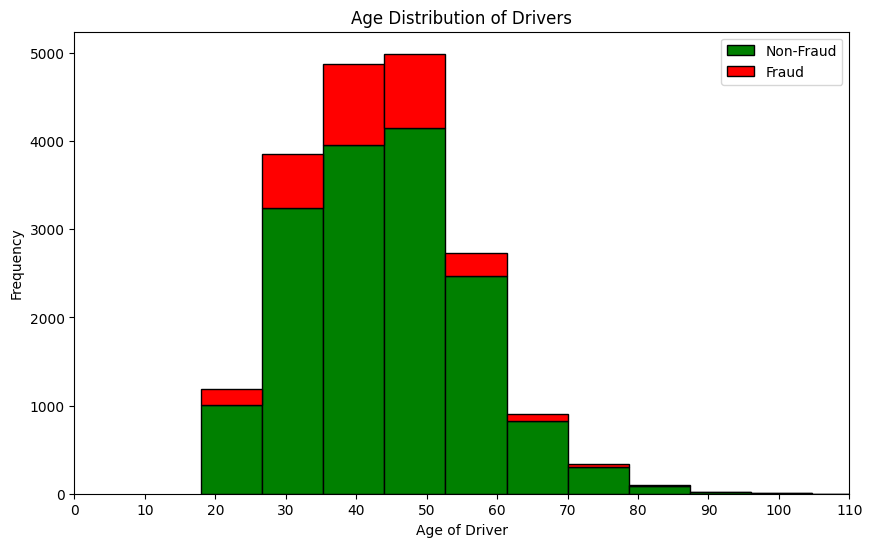

In [18]:
df_non_fraud = df[df['fraud'] == 0]
df_fraud = df[df['fraud'] == 1]

plt.figure(figsize=(10, 6))
plt.hist([df_non_fraud['age_of_driver'], df_fraud['age_of_driver']], bins=30, edgecolor='black',
         color=['green', 'red'], label=['Non-Fraud', 'Fraud'], stacked=True)
plt.xlim(0, 110)
plt.xticks(range(0, 111, 10))

plt.title('Age Distribution of Drivers')
plt.xlabel('Age of Driver')
plt.ylabel('Frequency')
plt.legend()
plt.show()

####2: Heatmap of Correlations

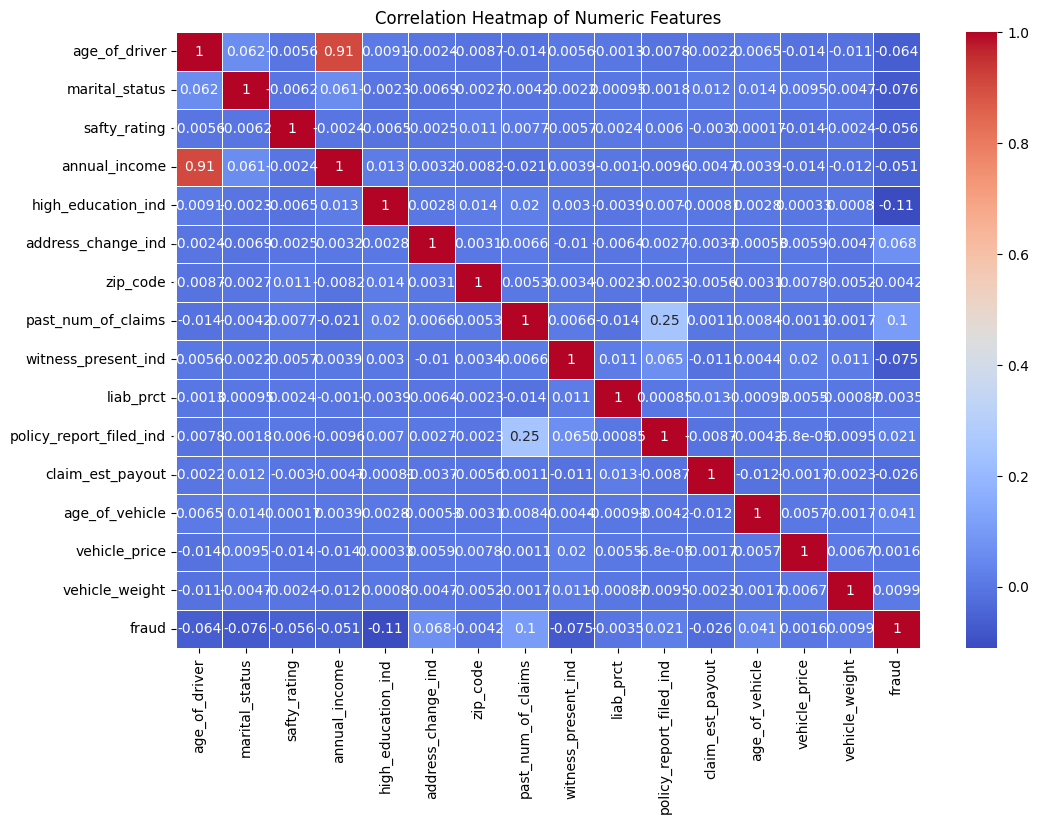

In [19]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['claim_number'])
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

####3: Fraud Rate by Vehicle Cateogry

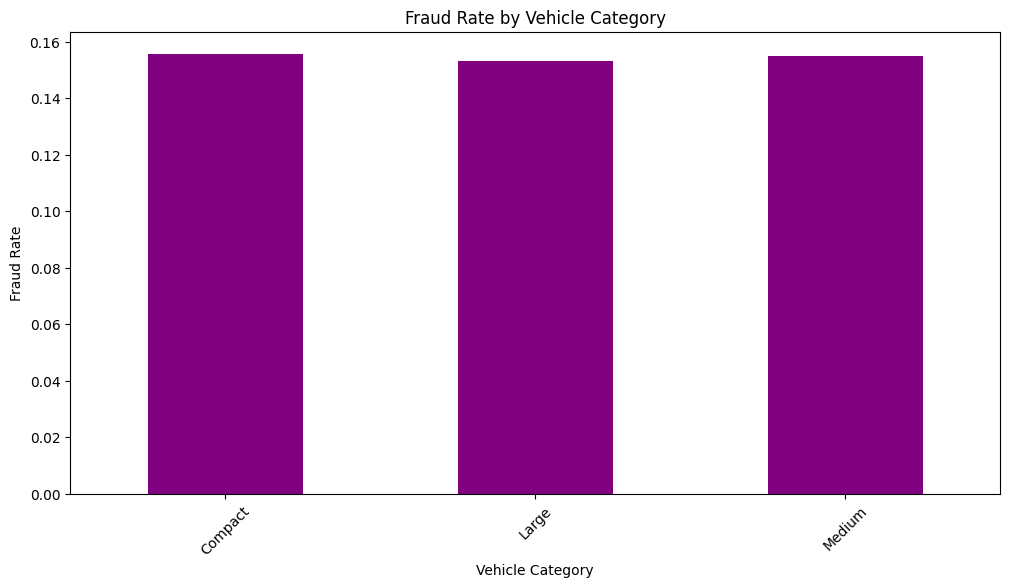

In [20]:
fraud_rate_vehicle_cat = df.groupby('vehicle_category')['fraud'].mean()

plt.figure(figsize=(12, 6))
fraud_rate_vehicle_cat.plot(kind='bar', color='purple')
plt.title('Fraud Rate by Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()


####4: Claim Payout by Age Group

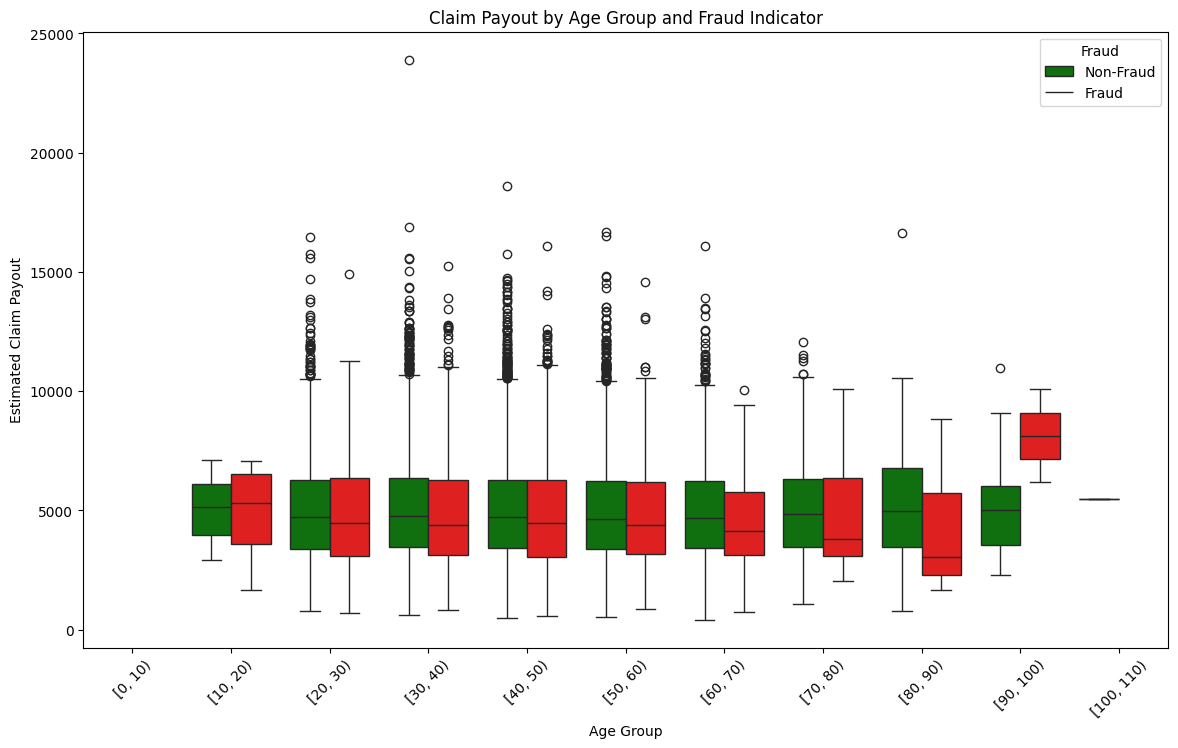

In [21]:

df['age_group'] = pd.cut(df['age_of_driver'], bins=range(0, 111, 10), right=False)

plt.figure(figsize=(14, 8))
sns.boxplot(x='age_group', y='claim_est_payout', hue='fraud', data=df, palette=['green', 'red'])
plt.title('Claim Payout by Age Group and Fraud Indicator')
plt.xlabel('Age Group')
plt.ylabel('Estimated Claim Payout')
plt.legend(title='Fraud', labels=['Non-Fraud', 'Fraud'])
plt.xticks(rotation=45)
plt.show()

####5: Education vs Income

<ipython-input-22-390d5d774087>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='high_education_ind', y='annual_income', data=df, palette=['blue', 'orange'])


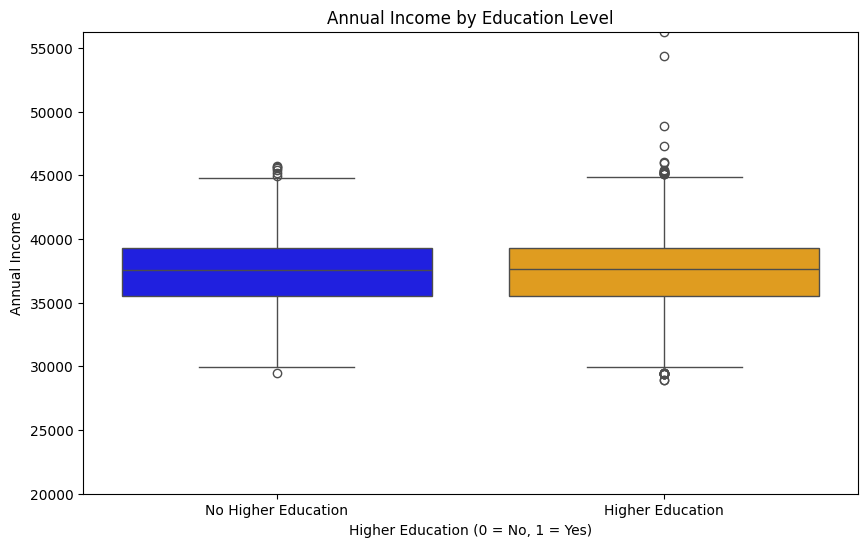

In [22]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='high_education_ind', y='annual_income', data=df, palette=['blue', 'orange'])
plt.ylim(20000, df['annual_income'].max())
plt.title('Annual Income by Education Level')
plt.xlabel('Higher Education (0 = No, 1 = Yes)')
plt.ylabel('Annual Income')
plt.xticks(ticks=[0, 1], labels=['No Higher Education', 'Higher Education'])
plt.show()

### 🟢 Tables

####Table 1: Average Claim By Gender

In [23]:
avg_claim_by_gender = df.groupby('gender')['claim_est_payout'].mean().reset_index()
avg_claim_by_gender

,gender,claim_est_payout
0,F,4990.148816
1,M,5004.220206


####Table 2: Fraud Claims by Marital Status

In [24]:
claims_fraud_by_marital_status = df.groupby('marital_status').agg(
    total_claims=('claim_number', 'count'),
    total_fraud_cases=('fraud', 'sum')
).reset_index()

# Adding percentage of fraud cases
claims_fraud_by_marital_status['fraud_percentage'] = (claims_fraud_by_marital_status['total_fraud_cases'] / claims_fraud_by_marital_status['total_claims']) * 100

claims_fraud_by_marital_status

,marital_status,total_claims,total_fraud_cases,fraud_percentage
0,0.0,5383,1067,19.821661
1,1.0,13613,1871,13.744215


####Table 3: Liability % by Accident Site

In [25]:
avg_liab_by_accident_site = df.groupby('accident_site')['liab_prct'].mean().reset_index()
avg_liab_by_accident_site

,accident_site,liab_prct
0,Highway,49.860300
1,Local,49.595430
2,Parking Lot,48.900035


####Table 4: Fraud proportion by vehicle type and color

In [26]:
fraud_by_vehicle = df.groupby(['vehicle_category', 'vehicle_color']).agg(
    total_claims=('fraud', 'count'),
    total_fraud_cases=('fraud', 'sum')
).reset_index()

# Adding proportion of fraud cases
fraud_by_vehicle['fraud_proportion'] = (fraud_by_vehicle['total_fraud_cases'] / fraud_by_vehicle['total_claims']) * 100

# Displaying the table
print(fraud_by_vehicle[['vehicle_category', 'vehicle_color', 'fraud_proportion']])

   vehicle_category vehicle_color  fraud_proportion
0           Compact         black         16.245884
1           Compact          blue         15.736607
2           Compact          gray         15.558061
3           Compact         other         13.453390
4           Compact           red         14.683816
5           Compact        silver         16.572077
6           Compact         white         16.843220
7             Large         black         16.289593
8             Large          blue         16.855204
9             Large          gray         14.773980
10            Large         other         14.221725
11            Large           red         14.285714
12            Large        silver         14.968153
13            Large         white         15.867945
14           Medium         black         15.294118
15           Medium          blue         16.075388
16           Medium          gray         16.444444
17           Medium         other         16.241299
18          

####Table 5: Fraud % by day of the week

In [27]:
# Proportion of fraud cases by day of the week
fraud_by_day_of_week = df.groupby('claim_day_of_week').agg(
    total_claims=('fraud', 'count'),
    total_fraud_cases=('fraud', 'sum')
).reset_index()

# Adding proportion of fraud cases
fraud_by_day_of_week['fraud_proportion'] = (fraud_by_day_of_week['total_fraud_cases'] / fraud_by_day_of_week['total_claims']) * 100

# Displaying the table
print(fraud_by_day_of_week[['claim_day_of_week', 'fraud_proportion']])

  claim_day_of_week  fraud_proportion
0            Friday         14.106464
1            Monday         14.507959
2          Saturday         15.961396
3            Sunday         16.611173
4          Thursday         15.655296
5           Tuesday         15.325810
6         Wednesday         16.062757


# 🔵  Modeling

In [28]:
# Random Forest Classifier

RFC = RandomForestClassifier(min_samples_leaf=10,min_samples_split=10,n_estimators=200,random_state=5)
RFC = RFC.fit(X_train,y_train)

RFC_train_preds = RFC.predict(X_train)
RFC_test_preds = RFC.predict(X_test)

cutoff = 0.55    # changing the cutoff

RFC_train_probs = RFC.predict_proba(X_train)[:, 1]
RFC_test_probs = RFC.predict_proba(X_test)[:, 1]

# Apply the cutoff threshold to the predicted probabilities
RFC_train_preds_cutoff = (RFC_train_probs >= cutoff).astype(int)
RFC_test_preds_cutoff = (RFC_test_probs >= cutoff).astype(int)

# Calculate the weighted F1 scores for the specified cutoff
RFC_train_f1_weighted_cutoff = f1_score(y_train, RFC_train_preds_cutoff, average='weighted')
RFC_test_f1_weighted_cutoff = f1_score(y_test, RFC_test_preds_cutoff, average='weighted')

# Print the weighted F1 scores for the specified cutoff
print("Weighted F1 Score (Training - Cutoff 0.6):", RFC_train_f1_weighted_cutoff)
print("Weighted F1 Score (Testing - Cutoff 0.6):", RFC_test_f1_weighted_cutoff)

Weighted F1 Score (Training - Cutoff 0.6): 0.9702663849091175
Weighted F1 Score (Testing - Cutoff 0.6): 0.7970706748427354


In [29]:
#Gradient Boosting Classifier Model
GBC = GradientBoostingClassifier(min_samples_leaf=15,random_state=5)
GBC = GBC.fit(X_train,y_train)

GBC_train_preds = GBC.predict(X_train)
GBC_test_preds = GBC.predict(X_test)

cutoff_threshold = 0.5  # Adjust this value as needed

# Predict probabilities on training and testing data
GBC_train_probs = GBC.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
GBC_test_probs = GBC.predict_proba(X_test)[:, 1]    # Probabilities for the positive class

# Apply threshold to determine class predictions
GBC_train_preds_cutoff = np.where(GBC_train_probs > cutoff_threshold, 1, 0)
GBC_test_preds_cutoff = np.where(GBC_test_probs > cutoff_threshold, 1, 0)

# Calculate weighted F1 score with the new cutoff
GBC_train_f1_weighted_cutoff = f1_score(y_train, GBC_train_preds_cutoff, average='weighted')
GBC_test_f1_weighted_cutoff = f1_score(y_test, GBC_test_preds_cutoff, average='weighted')

print("Weighted F1 Score (Training) with cutoff {:.2f}: {}".format(cutoff_threshold, GBC_train_f1_weighted_cutoff))
print("Weighted F1 Score (Testing) with cutoff {:.2f}: {}".format(cutoff_threshold, GBC_test_f1_weighted_cutoff))

Weighted F1 Score (Training) with cutoff 0.50: 0.6923143794000582
Weighted F1 Score (Testing) with cutoff 0.50: 0.6974013984059048


# 🔵 Model Results

## 🟢 Test for Leakage of Test Set

In [30]:
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,past_num_of_claims,witness_present_ind,...,vehicle_color_red,vehicle_color_silver,vehicle_color_white,claim_day_of_week_Friday,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday
0,0.076923,0.0,0.0,0.888889,0.646386,1.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.134615,0.0,1.0,0.747475,0.705363,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.084615,0.0,0.0,0.606061,0.655377,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.000000,1.0,0.0,0.818182,0.513736,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.076923,1.0,1.0,0.828283,0.646297,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
X_test.shape

(3800, 39)

## 🟢 Confusion Matrix

In [32]:
print('Training Confusion Matrix: ')
print(confusion_matrix(y_train, GBC_train_preds_cutoff))
print('Testing Confusion Matrix: ')
print(confusion_matrix(y_test, GBC_test_preds_cutoff))

Training Confusion Matrix: 
[[8811 4042]
 [3867 8986]]
Testing Confusion Matrix: 
[[2121 1088]
 [ 238  353]]


## 🟢 Classification Report

In [33]:
print(classification_report(y_train, GBC_train_preds_cutoff))
print(classification_report(y_test, GBC_test_preds_cutoff))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     12853
           1       0.69      0.70      0.69     12853

    accuracy                           0.69     25706
   macro avg       0.69      0.69      0.69     25706
weighted avg       0.69      0.69      0.69     25706

              precision    recall  f1-score   support

           0       0.90      0.66      0.76      3209
           1       0.24      0.60      0.35       591

    accuracy                           0.65      3800
   macro avg       0.57      0.63      0.55      3800
weighted avg       0.80      0.65      0.70      3800



# 🔵 Interpretability and Discussion

## 🟢 Permutation Importance

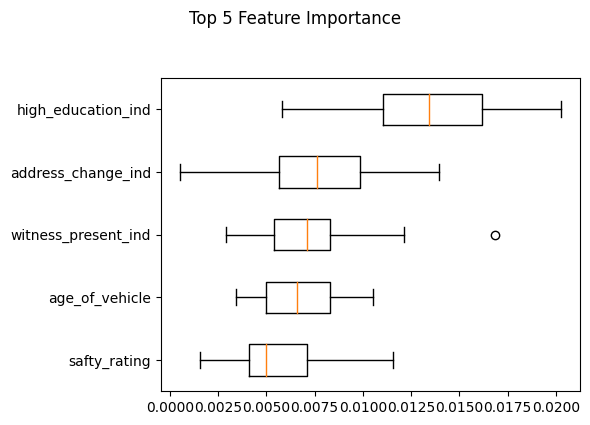

In [34]:
# clf is trained RandomForestClassifier
clf = GBC

result = permutation_importance(clf, X_test, y_test, n_repeats=15, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# Get the indices of the top 5 most important features
top_5_perm_sorted_idx = perm_sorted_idx[-5:]

# Sort the indices of the top 5 features
top_5_perm_sorted_idx = top_5_perm_sorted_idx[np.argsort(result.importances_mean[top_5_perm_sorted_idx])]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# Box plot of the top 5 variables
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[top_5_perm_sorted_idx].T, vert=False,
            labels=X_test.columns[top_5_perm_sorted_idx])
fig.suptitle('Top 5 Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

In [39]:
top_5_perm_sorted_idx

array([ 3, 13,  9,  6,  5])

In [40]:
tmp.iloc[[5,6,9,13,3]]

,0
5,high_education_ind
6,address_change_ind
9,witness_present_ind
13,age_of_vehicle
3,safty_rating


## 🟢 Partial Dependency

In [41]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=4,
                  ncols=4, figsize=(12, 12), sharex=False, sharey=True,
                  num_grid_points = 10, # DW added this on 4/27/2022!
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False,
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()

    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
<ipython-input-41-fd542e832986>:17: UserWarning: 

`distplot` is a deprecat

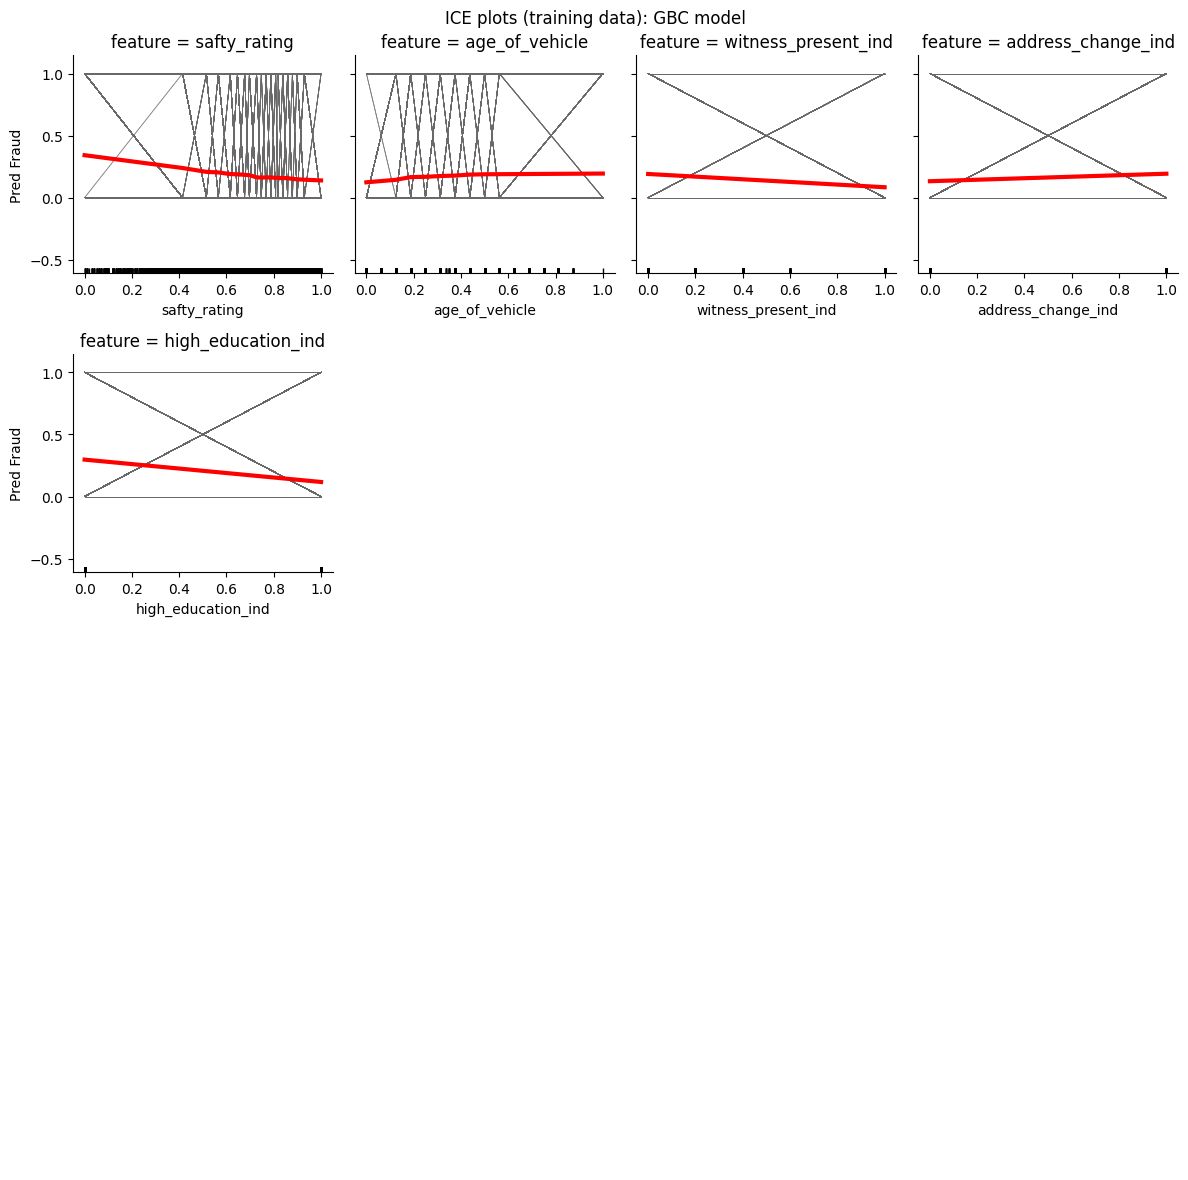

In [43]:
# columns to plot
features = [X_train.columns[i] for i in top_5_perm_sorted_idx]

# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=X_train, column=feat, predict=RFC.predict,num_grid_points=20)
                 for feat in features}

plot_ice_grid(train_ice_dfs, X_train, features,
                    ax_ylabel='Pred Fraud', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
#plt.ylim([0,50])
plt.suptitle('ICE plots (training data): GBC model')
plt.subplots_adjust(top=0.89)
plt.tight_layout()
plt.show()

# 🔵 Business Recomendation & Conclusions

My RFC model has a very high f1 score(0.7971) for the test partition but still doesn't do the best job of predicting fraud. However, given our variables that are important, we can consider looking closer at cases where the individual didn't attain higher education and has a higher number of previous claims. As these are the 2 biggest indicators of fraud, performing this exercise on the set that is considered not fraud could be a good way for us to capture a portion of the cases that we are missing. Additionally, I have devleloped a model using Gradient Boosting Classifier that achieves a consistent F1 score of 0.7 for both training and test data which is more stable and optimized. I recommend adopting this model to the business team.



1.   I learned that simply having a good F1 score doesn't mean the model is good. For a model to really be helpful to us, it should capture almost all of the actual fraud cases, and if we have a bunch of "false alarms" that is okay because we will be able to figure that out while actually capturing fraud.
2.   It was interesting to see during the EDA that the age range most likely to commit fraud was from mid-late 20's to early 50's. I wouldn't have expected proportionally less fraud in the 18-~25 age range. To speculate, it could be because once you've had insurance for a while, you get an understanding of how the system works and believe you can "game" the system. On our correlation map, I saw the only strong correlation between age and income, which could be how the model is capturing this information.
4.   Sometimes PCA doesn't make the model better. Initially I thought it could make sense to use PCA to improve our model and it did, but when I changed to the model we ended up using, I saw a significant jump in our F1 score.
5.   Given our table 2, which looked at fraud claims by marital status, I expected to see this variable deemed important. However, despite the signficiant difference in fraud proportionally by martial status, this didn't make it into the top 5.